In [2]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hshma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
# Import Dataset
strictdepression_df = pd.read_csv('./Stored_Dataframes/strict_depression_df_with_topics.csv')
topic_depression_df = strictdepression_df[['clean_text']]
topic_depression_df.head()

,clean_text
0,my anxiety levels are literally through the ro...
1,Corona Chronicles: Anti-social distancing #lat...
2,"COVID-19 symptoms: loss of taste and smell, co..."
3,I will admit we where afraid of the Corona vir...
4,#smog over #losangeles seems to be gone. This ...


In [6]:
# Convert to list
data = topic_depression_df.clean_text.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'"," ", sent) for sent in data]

pprint(data[:2])

['my anxiety levels are literally through the roof right now i need this '
 'corona shit to end right now',
 'Corona Chronicles: Anti-social distancing #latergram #thatplanebetterbeempty '
 '@ San Mateo–Hayward Bridge ']


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])

[['my', 'anxiety', 'levels', 'are', 'literally', 'through', 'the', 'roof', 'right', 'now', 'need', 'this', 'corona', 'shit', 'to', 'end', 'right', 'now']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['my', 'anxiety', 'levels', 'are', 'literally', 'through', 'the', 'roof', 'right', 'now', 'need', 'this', 'corona', 'shit', 'to', 'end', 'right', 'now']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# nlp = en_core_web_sm.load(disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

[!] Skipping model package dependencies and setting `--no-deps`. You don't seem
to have the spaCy package itself installed (maybe because you've built from
source?), so installing the model dependencies would cause spaCy to be
downloaded, which probably isn't what you want. If the model package has other
dependencies, you'll have to install them manually.
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[['anxiety', 'level', 'literally', 'roof', 'need', 'corona', 'shit', 'end', 'right'], ['corona', 'chronicle']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:3])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(1, 1), (9, 1)], [(10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.032*"covid" + 0.020*"anxiety" + 0.015*"pandemic" + 0.015*"depression" + '
  '0.012*"people" + 0.012*"get" + 0.011*"go" + 0.010*"amp" + 0.009*"work" + '
  '0.008*"feel"'),
 (1,
  '0.115*"empty" + 0.030*"mask" + 0.017*"wear" + 0.013*"sit" + 0.009*"stadium" '
  '+ 0.009*"social_distancing" + 0.008*"travel" + 0.007*"seat" + 0.007*"game" '
  '+ 0.005*"restaurant"'),
 (2,
  '0.122*"suicide" + 0.120*"copy" + 0.079*"could" + 0.076*"lockdown" + '
  '0.068*"try" + 0.063*"figure" + 0.055*"retweet" + 0.055*"friend" + '
  '0.054*"hotline" + 0.052*"demonstrate"')]


In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.311314793329461

Coherence Score:  0.4645616849501885


In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\hshma\anaconda3\envs\D3M\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.275723 -0.186997       1        1  78.503918
2     -0.325820 -0.112235       2        1  11.022606
1      0.050097  0.299232       3        1  10.473476, topic_info=          Term         Freq        Total Category  logprob  loglift
74     suicide  4430.000000  4430.000000  Default  30.0000  30.0000
738       copy  4360.000000  4360.000000  Default  29.0000  29.0000
18       empty  3983.000000  3983.000000  Default  28.0000  28.0000
200      could  2861.000000  2861.000000  Default  27.0000  27.0000
174   lockdown  2755.000000  2755.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1505      half   113.452995   254.027234   Topic3  -5.7180   1.4503
2220     stand   108.042828   204.198778   Topic3  -5.7669   1.6198
700       play   112.098663   289.160070   Topic3  -5.7300   1.3087
1089      pack   100.092972   157.005947   Topic3  -5.8433   1.8061
1025      full   103.219599   297.131239   Topic3  -5.8125   1.1990

[142 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
26        3  0.994577               air
2114      2  0.993458    always_listene
736       2  0.999761  always_listening
119       1  0.999774               amp
0         1  0.999919           anxiety
...     ...       ...               ...
48        1  0.087375              wear
48        3  0.912757              wear
169       1  0.998988              week
117       1  0.999675              work
170       1  0.999591              year

[140 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print("done num_topics={}".format(num_topics))

    return model_list, coherence_values

In [17]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

done num_topics=2
done num_topics=3
done num_topics=4
done num_topics=5
done num_topics=6
done num_topics=7
done num_topics=8
done num_topics=9


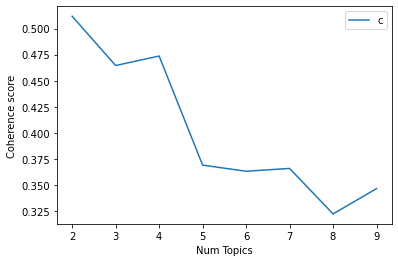

In [18]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5117
Num Topics = 3  has Coherence Value of 0.4646
Num Topics = 4  has Coherence Value of 0.4737
Num Topics = 5  has Coherence Value of 0.3692
Num Topics = 6  has Coherence Value of 0.3634
Num Topics = 7  has Coherence Value of 0.3661
Num Topics = 8  has Coherence Value of 0.3225
Num Topics = 9  has Coherence Value of 0.3467


In [20]:
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.112*"suicide" + 0.110*"copy" + 0.072*"could" + 0.070*"lockdown" + '
  '0.062*"try" + 0.058*"figure" + 0.051*"retweet" + 0.050*"friend" + '
  '0.050*"hotline" + 0.048*"demonstrate"'),
 (1,
  '0.029*"covid" + 0.018*"anxiety" + 0.014*"pandemic" + 0.014*"depression" + '
  '0.011*"people" + 0.011*"get" + 0.010*"empty" + 0.010*"go" + 0.009*"amp" + '
  '0.008*"work"')]


In [21]:
# optimal_model[corpus][0]
print(optimal_model[corpus][3])
# print(optimal_model[corpus][4])
# print(sorted(optimal_model[corpus][3], key=lambda x: (x[1]), reverse=True))
tst=optimal_model[corpus][3][0]
print(sorted(tst, key=lambda x: (x[1]), reverse=True))

([(1, 0.99343866)], [(15, [1]), (16, [1]), (17, [1]), (18, [1]), (19, [1]), (20, [1]), (21, [1]), (22, [1]), (23, [1]), (24, [1]), (25, [1])], [(15, [(1, 0.9995421)]), (16, [(1, 0.9996135)]), (17, [(1, 0.99983287)]), (18, [(1, 0.99998844)]), (19, [(1, 0.9999828)]), (20, [(1, 0.9999597)]), (21, [(1, 0.9998601)]), (22, [(1, 0.9998061)]), (23, [(1, 0.99988806)]), (24, [(1, 0.9997639)]), (25, [(1, 0.99995244)])])
[(1, 0.99343866)]


In [22]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = row[0]
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9920,"covid, anxiety, pandemic, depression, people, ...",my anxiety levels are literally through the ro...
1,1,1.0,0.9657,"covid, anxiety, pandemic, depression, people, ...",Corona Chronicles: Anti-social distancing #lat...
2,2,1.0,0.9861,"covid, anxiety, pandemic, depression, people, ...","COVID-19 symptoms: loss of taste and smell, co..."
3,3,1.0,0.9934,"covid, anxiety, pandemic, depression, people, ...",I will admit we where afraid of the Corona vir...
4,4,1.0,0.9939,"covid, anxiety, pandemic, depression, people, ...",#smog over #losangeles seems to be gone. This ...
5,5,1.0,0.9959,"covid, anxiety, pandemic, depression, people, ...","@4lisaguerrero Unfortunately , we will be seei..."
6,6,1.0,0.9961,"covid, anxiety, pandemic, depression, people, ...",#DoNotOpenCalifornia We are now seeing more cr...
7,7,1.0,0.8987,"covid, anxiety, pandemic, depression, people, ...",@NewsHour ya’ll realize there is absolutely no...
8,8,1.0,0.9957,"covid, anxiety, pandemic, depression, people, ...",Tops on the Senate agenda is not necessarily t...
9,9,1.0,0.9963,"covid, anxiety, pandemic, depression, people, ...",Idk about you guys but seeing a black man lync...


In [23]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9814,"suicide, copy, could, lockdown, try, figure, r...",Suicide figures are up 200% since lockdown. Co...
1,1.0,0.9976,"covid, anxiety, pandemic, depression, people, ...","Let’s not forget that Covid is running wild, k..."


In [24]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"covid, anxiety, pandemic, depression, people, ...",2487.0,0.0962
1.0,1.0,"covid, anxiety, pandemic, depression, people, ...",23375.0,0.9038
2.0,1.0,"covid, anxiety, pandemic, depression, people, ...",NaN,NaN
3.0,1.0,"covid, anxiety, pandemic, depression, people, ...",NaN,NaN
4.0,1.0,"covid, anxiety, pandemic, depression, people, ...",NaN,NaN
...,...,...,...,...
25857.0,1.0,"covid, anxiety, pandemic, depression, people, ...",NaN,NaN
25858.0,1.0,"covid, anxiety, pandemic, depression, people, ...",NaN,NaN
25859.0,1.0,"covid, anxiety, pandemic, depression, people, ...",NaN,NaN
25860.0,1.0,"covid, anxiety, pandemic, depression, people, ...",NaN,NaN
